# ML Experiment 8: Classification and Regression Tree (CART)
**Aim : Implement CART learning algorithms to perform categorization.**

In [1]:
import kagglehub
pima_indians_diabetes_database_path = kagglehub.dataset_download('uciml/pima-indians-diabetes-database')

print('Data source import complete.')


100%|██████████| 8.91k/8.91k [00:00<00:00, 4.12MB/s]

Extracting files...
Data source import complete.


Classification and Regression Trees is a classification method which uses historical data to construct so-called decision trees. Decision trees are then used to classify new data. In order to use CART we need to know number of classes a priori.

**CART methodology consists of tree parts:**

1. Construction of maximum tree

2. Choice of the right tree size

3. Classification of new data using constructed tree

The aim is to transform the complex structures in the data set into simple decision structures. Heterogeneous data sets are divided into homogeneous subgroups according to a specified target variable.

# Modeling using CART

In [2]:
import warnings
import joblib
#import pydotplus
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier, export_graphviz, export_text
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, validation_curve
#from skompiler import skompile

In [3]:
#Reading the dataset
df = pd.read_csv(pima_indians_diabetes_database_path + "/diabetes.csv")

In [4]:
# The first 5 observation units of the data set were accessed.
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
y = df["Outcome"]
X = df.drop(["Outcome"], axis=1)

In [6]:
# Model
cart_model = DecisionTreeClassifier(random_state=17).fit(X, y)

In [7]:
#y_pred for Confusion Matrix  :
y_pred = cart_model.predict(X)

In [8]:
#y_prob for AUC:
y_prob = cart_model.predict_proba(X)[:, 1]

In [9]:
# Confusion matrix
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       500
           1       1.00      1.00      1.00       268

    accuracy                           1.00       768
   macro avg       1.00      1.00      1.00       768
weighted avg       1.00      1.00      1.00       768



In [10]:
# AUC
roc_auc_score(y, y_prob)

1.0

# Evaluation of Success with the Holdout Method

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=85)

In [12]:
cart_model = DecisionTreeClassifier(random_state=17).fit(X_train, y_train)

In [13]:
# Train Error
y_pred = cart_model.predict(X_train)
y_prob = cart_model.predict_proba(X_train)[:, 1]
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       349
           1       1.00      1.00      1.00       188

    accuracy                           1.00       537
   macro avg       1.00      1.00      1.00       537
weighted avg       1.00      1.00      1.00       537



In [14]:
roc_auc_score(y_train, y_prob)

1.0

In [15]:
# Test Error
y_pred = cart_model.predict(X_test)
y_prob = cart_model.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.76      0.76       151
           1       0.56      0.56      0.56        80

    accuracy                           0.69       231
   macro avg       0.66      0.66      0.66       231
weighted avg       0.69      0.69      0.69       231



In [16]:
roc_auc_score(y_test, y_prob)

0.6620447019867549

# Evaluation of Success with Cross Validation

In [17]:
cart_model = DecisionTreeClassifier(random_state=17).fit(X, y)

In [18]:
cv_results = cross_validate(cart_model,
                            X, y,
                            cv=10,
                            scoring=["accuracy", "f1", "roc_auc"])

In [19]:
cv_results['test_accuracy'].mean()

0.7148496240601504

In [20]:
cv_results['test_f1'].mean()

0.5780669232692448

In [21]:
cv_results['test_roc_auc'].mean()

0.6796239316239316

# Hyperparameter Optimization with GridSearchCV

In [22]:
cart_model.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 17,
 'splitter': 'best'}

In [23]:
# Hyperparameter set to search:
cart_params = {'max_depth': range(1, 11),
               "min_samples_split": range(2, 20)}

In [24]:
# GridSearchCV
cart_best_grid = GridSearchCV(cart_model,
                              cart_params,
                              cv=5,
                              n_jobs=-1,
                              verbose=True).fit(X, y)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


In [25]:
# Best hyper parameter values:
cart_best_grid.best_params_

{'max_depth': 5, 'min_samples_split': 12}

In [26]:
# Best score:
cart_best_grid.best_score_

0.7500806383159324

In [27]:
random = X.sample(1, random_state=45)
print(random)

     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
195            5      158             84             41      210  39.4   

     DiabetesPedigreeFunction  Age  
195                     0.395   29  


In [28]:
cart_best_grid.predict(random)

array([1])

# 5. Final Model

In [29]:
cart_final = DecisionTreeClassifier(**cart_best_grid.best_params_,
                                    random_state=17).fit(X, y)

In [30]:
cart_final.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 12,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 17,
 'splitter': 'best'}

In [31]:
# Another way to assign the best parameters to the model:
cart_final = cart_model.set_params(**cart_best_grid.best_params_).fit(X, y)

In [32]:
# CV error of final model:
cv_results = cross_validate(cart_final,
                            X, y,
                            cv=10,
                            scoring=["accuracy", "f1", "roc_auc"])

In [33]:
cv_results['test_accuracy'].mean()


0.7292207792207792

In [34]:
cv_results['test_f1'].mean()


0.5633111151435928

In [35]:
cv_results['test_roc_auc'].mean()


0.7649672364672366

# 6. Feature Importance

In [36]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

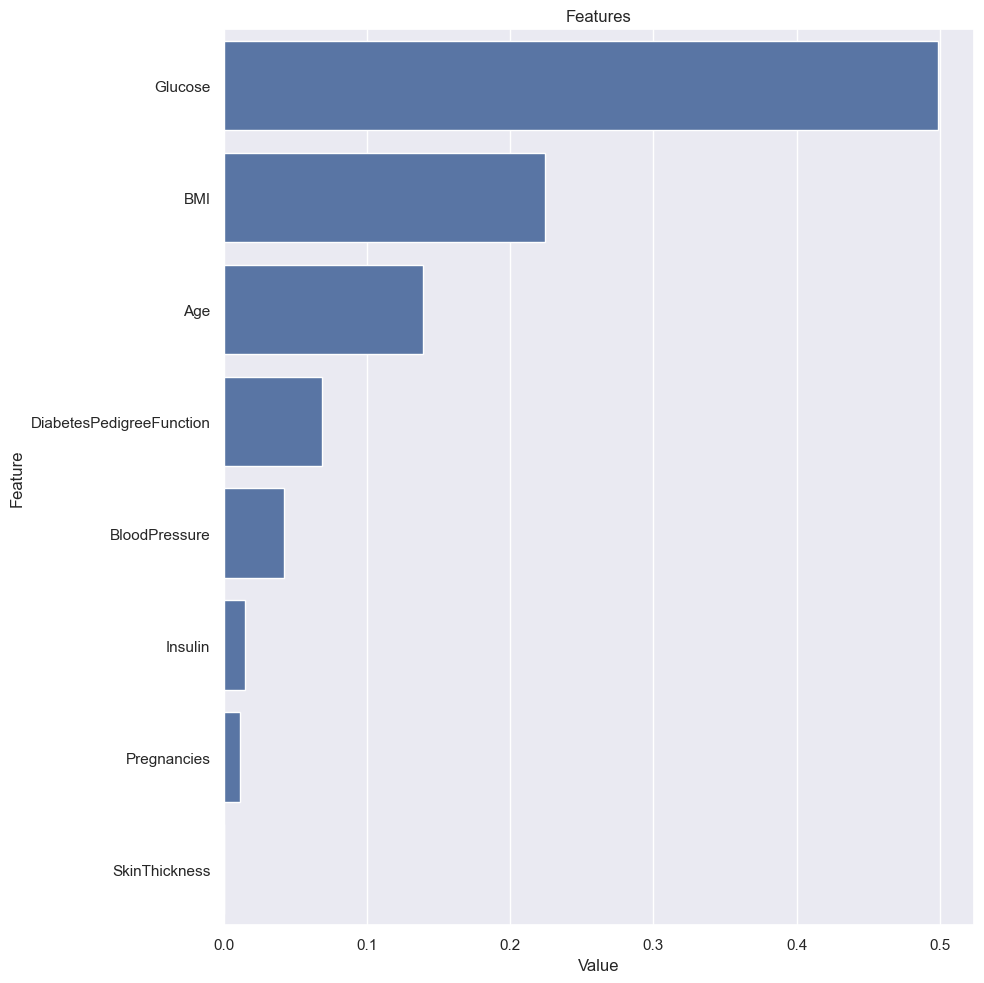

In [37]:
plot_importance(cart_final, X, 15)

# 7. Analyzing Model Complexity with Learning Curves

In [38]:
train_score, test_score = validation_curve(
    cart_final, X=X, y=y,
    param_name='max_depth',
    param_range=range(1, 11),
    scoring="roc_auc",
    cv=10)

In [39]:
mean_train_score = np.mean(train_score, axis=1)

In [40]:
mean_test_score = np.mean(test_score, axis=1)

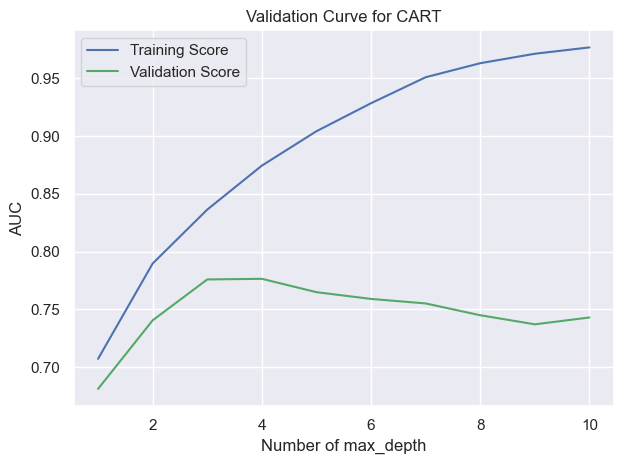

In [41]:
plt.plot(range(1, 11), mean_train_score,
         label="Training Score", color='b')
plt.plot(range(1, 11), mean_test_score,
         label="Validation Score", color='g')

plt.title("Validation Curve for CART")
plt.xlabel("Number of max_depth")
plt.ylabel("AUC")
plt.tight_layout()
plt.legend(loc='best')
plt.show()

# 8. Extracting Decision Rules

In [42]:
tree_rules = export_text(cart_model, feature_names=list(X.columns))
print(tree_rules)

|--- Glucose <= 127.50
|   |--- Age <= 28.50
|   |   |--- BMI <= 45.40
|   |   |   |--- BMI <= 30.95
|   |   |   |   |--- Pregnancies <= 7.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- Pregnancies >  7.50
|   |   |   |   |   |--- class: 1
|   |   |   |--- BMI >  30.95
|   |   |   |   |--- DiabetesPedigreeFunction <= 0.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- DiabetesPedigreeFunction >  0.50
|   |   |   |   |   |--- class: 0
|   |   |--- BMI >  45.40
|   |   |   |--- class: 1
|   |--- Age >  28.50
|   |   |--- BMI <= 26.35
|   |   |   |--- BMI <= 9.65
|   |   |   |   |--- class: 1
|   |   |   |--- BMI >  9.65
|   |   |   |   |--- class: 0
|   |   |--- BMI >  26.35
|   |   |   |--- Glucose <= 99.50
|   |   |   |   |--- Glucose <= 28.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- Glucose >  28.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- Glucose >  99.50
|   |   |   |   |--- DiabetesPedigreeFunction <= 0.56
|   |   |   |   |   |--- class: 0